# I-Front Test

We first consider the simplest example, HII region expansion around a single source of ionizing radiation and  constant density field. 

This test is known as the ionization front (_I-front_) test and is a standard test in reionization [(Mellema+ 2006)](https://arxiv.org/abs/astro-ph/0508416).

In [2]:
import pyc2ray as pc2r
import numpy as np, matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import astropy.units as u

## Analytical Solution

Here, we consider a source emitting $\dot{N}_\gamma$ ionizing photons per unit time igniting in a medium of neutral hydrogen with number density $n_\mathrm{H}$.

The ionizing photons propagates resulting in a I-front with radius, $r_I$, that ionize the surrounding gas neutral gas. The I-front propagation speed, $v_I$, is determined by the balance between the flux of ionizing photons and the number of neutral atoms.

In [3]:
# Analytical Solution
Ngamma = 1e54 / u.s
nH = 1.87e-4 / u.cm**3
alpha_B = 2.59e-13 * u.cm**3 / u.s

r_S = ((3*Ngamma/(4*np.pi*alpha_B*nH**2))**(1./3)).to('kpc')
t_rec = (1.0 / (alpha_B*nH)).to('Myr')

print("r_S = ", r_S)
print("t_rec = ", t_rec)

def r_I(t):
    return r_S * (1.0 - np.exp(-t/t_rec))**(1./3)

def v_I(t):
    return (r_S/(3*t_rec) * (np.exp(-t/t_rec))/(1.0 - np.exp(-t/t_rec))**(2./3)).to('km/s')

r_S =  964.4778524776175 kpc
t_rec =  654.2664673678886 Myr


Calculate analytical solution and plot results.

In [82]:
t_evol = 5e8 # years

t_analytical = np.linspace(0, t_evol*u.yr, 200, endpoint=True).to('Myr')

r_analytical = r_I(t_analytical)
v_analytical = v_I(t_analytical[1:])

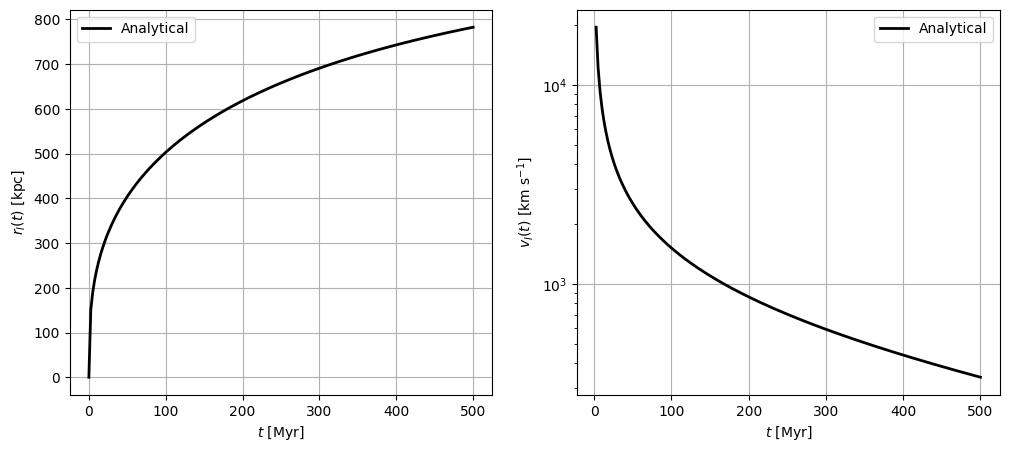

In [6]:
fig, axs = plt.subplots(figsize=(12,5), ncols=2, nrows=1)

axs[0].plot(t_analytical, r_analytical, color='black', ls='-', label="Analytical", lw=2)
axs[0].set_ylabel("$r_I(t)$ [kpc]")

axs[1].semilogy(t_analytical[1:],v_analytical,color='black',label="Analytical",lw=2)
axs[1].set_ylabel("$v_I(t)$ [km s$^{-1}$]")

for ax in axs:
    ax.set_xlabel("$t$ [Myr]")
    ax.grid()
    ax.legend()

## Numerical Solution

Here, we use pyC$^2$Ray to compute the I-front and test whether it provides the correct solution.

The coarseness of the numerical solution depends on the number of time steps. Here, we define the number of redshift steps we want to output. Increasing the value of `numzred` will refine the numerical solution and increase the computing time (`numzred=10` takes approximately 1.5 minutes).

In [75]:
numzred = 10

Define some global parameters and instance the test simulation class.

In [98]:
# Global parameters
num_steps_between_slices = 1

# Create C2Ray object
sim = pc2r.C2Ray_Test(paramfile='parameters_ifront.yml')

                 _________   ____            
    ____  __  __/ ____/__ \ / __ \____ ___  __
   / __ \/ / / / /    __/ // /_/ / __ `/ / / /
  / /_/ / /_/ / /___ / __// _, _/ /_/ / /_/ / 
 / .___/\__, /\____//____/_/ |_|\__,_/\__, /  
/_/    /____/                        /____/   

Welcome! Mesh size is N = 256.
Simulation Box size (comoving Mpc): 1.620e+00
Cosmology is off.
Using power-law opacity with 20,000 table points between tau=10^(-20) and tau=10^(4)
Using Black-Body sources with effective temperature T = 5.0e+04 K and Radius  1.437e-11 rsun
Spectrum Frequency Range: 3.288e+15 to 1.316e+17 Hz
This is Energy:           1.360e+01 to 5.442e+02 eV
Integrating photoionization rates tables...
INFO: No heating rates

---- Calculated Clumping Factor (constant model):
 min, mean and max clumping : 1.000e+00  1.000e+00  1.000e+00

---- Calculated Mean-Free Path (constant model):
Maximum comoving distance for photons from source mfp = 15.00 cMpc (constant model).
 This corresponds to 2370.

Read the source file and define some redshift step.

In [99]:
# Generate redshift list (test case)
zred_array = sim.generate_redshift_array(numzred+1,t_evol/numzred)

# Read sources
numsrc = 2
srcpos, srcflux = sim.read_sources("src.txt", numsrc)

# Use the second source only
srcpos = srcpos[:,1][:,None]
srcflux = np.array([srcflux[1]])

In [100]:
xc = np.linspace(0, sim.boxsize*1000/2, sim.N//2)

# Start the timer ot measure the wall clock time
timer = pc2r.Timer()
timer.start()

z_init = sim.zred
t_num = []
t_ave = []

r_num = []
v_num = []

# Loop over redshifts
for k in range(len(zred_array)-1):
    # Compute timestep of current redshift slice
    zi = zred_array[k]
    zf = zred_array[k+1]
    
    sim.printlog("\n=================================\nDoing redshift %.3f to %.3f\n=================================\n" %(zi, zf), sim.logfile)

    # Compute timestep of current redshift slice
    dt = sim.set_timestep(zi,zf,num_steps_between_slices)
    
    # Set density (when cosmological is false, zi has no effect)
    sim.density_init(zi)
    
    # Set redshift to current slice redshift
    sim.zred = zi
 
    # Do num_steps_between_slices timesteps
    for t in range(num_steps_between_slices):
        sim.printlog("\n --- Timestep %d. Redshift: z = %.3f --- \n" %(t+1, sim.zred), sim.logfile)

        # Evolve Cosmology: increment redshift and scale physical quantities (density, proper cell size, etc.). If cosmology is disabled in parameter, this step does nothing (checked internally by the class)
        if(sim.cosmological):
            sim.cosmo_evolve(dt)

        # Evolve the simulation: raytrace -> photoionization rates -> chemistry -> until convergence
        sim.evolve3D(dt, srcflux, srcpos)
        
        # Register elapsed Wall clock time
        tnow = timer.lap('k=%d, t=%d' %(k,t))
    
        # Compute the position of the I-front
        
        #tt = 
        #t_num.append()
        r_num.append(np.interp(0.5, sim.xh[sim.N//2:,sim.N//2,sim.N//2], xc))
        
        """
        # Compute the I-front velocity
        if(k > 0):
            tavei = (sim.cosmology.age(z=zi) + sim.cosmology.age(z=zf))/2 - sim.cosmology.age(z=z_init)
            t_ave.append(tavei)

            front_vel_coarse.append(kpc_in_km/myr_in_s * (front_pos_coarse[k]-front_pos_coarse[k-j]) / (tt_[k]-tt_[k-j]))
            v_num[k-1] = 
        """
        
# stop the timer and print the summary
timer.stop()
sim.printlog(timer.summary, sim.logfile)

Calling evolve3D...
dr [Mpc]: 6.328e-03
dt [years]: 5.000e+07
Running on 1 source(s), total normalized ionizing flux: 1.00e+07
Mean density (cgs): 1.870e-04, Mean ionized fraction: 1.200e-03
Convergence Criterion (Number of points):  0

Rank=0 is doing Raytracing... took 1.93s.
Average number of subboxes: 1, Total photon loss: 2.965e+43
Doing Chemistry... took  1.2 s.
Number of non-converged points: 22983 of 16777216 ( 0.137 % ), Relative change in ionfrac:  1.49e+03
Rank=0 is doing Raytracing... took 1.98s.
Average number of subboxes: 1, Total photon loss: 4.559e+43
Doing Chemistry... took  1.2 s.
Number of non-converged points: 48372 of 16777216 ( 0.288 % ), Relative change in ionfrac:  2.51e-01
Rank=0 is doing Raytracing... took 1.80s.
Average number of subboxes: 1, Total photon loss: 6.377e+43
Doing Chemistry... took  1.2 s.
Number of non-converged points: 78070 of 16777216 ( 0.465 % ), Relative change in ionfrac:  3.05e-01
Rank=0 is doing Raytracing... took 2.12s.
Average number o

Rank=0 is doing Raytracing... took 1.58s.
Average number of subboxes: 1, Total photon loss: 5.685e+46
Doing Chemistry... took  1.2 s.
Number of non-converged points: 1146294 of 16777216 ( 6.832 % ), Relative change in ionfrac:  5.32e-02
Rank=0 is doing Raytracing... took 1.59s.
Average number of subboxes: 1, Total photon loss: 7.069e+46
Doing Chemistry... took  1.2 s.
Number of non-converged points: 1179168 of 16777216 ( 7.028 % ), Relative change in ionfrac:  5.16e-02
Rank=0 is doing Raytracing... took 1.65s.
Average number of subboxes: 1, Total photon loss: 8.816e+46
Doing Chemistry... took  1.3 s.
Number of non-converged points: 1210030 of 16777216 ( 7.212 % ), Relative change in ionfrac:  5.01e-02
Rank=0 is doing Raytracing... took 1.69s.
Average number of subboxes: 1, Total photon loss: 1.103e+47
Doing Chemistry... took  1.3 s.
Number of non-converged points: 1242288 of 16777216 ( 7.405 % ), Relative change in ionfrac:  4.87e-02
Rank=0 is doing Raytracing... took 1.70s.
Average nu

Doing Chemistry... took  1.4 s.
Number of non-converged points: 1665648 of 16777216 ( 9.928 % ), Relative change in ionfrac:  1.14e-02
Rank=0 is doing Raytracing... took 1.68s.
Average number of subboxes: 1, Total photon loss: 1.194e+53
Doing Chemistry... took  1.4 s.
Number of non-converged points: 1573216 of 16777216 ( 9.377 % ), Relative change in ionfrac:  9.21e-03
Rank=0 is doing Raytracing... took 1.69s.
Average number of subboxes: 1, Total photon loss: 1.336e+53
Doing Chemistry... took  1.5 s.
Number of non-converged points: 1466492 of 16777216 ( 8.741 % ), Relative change in ionfrac:  7.10e-03
Rank=0 is doing Raytracing... took 1.71s.
Average number of subboxes: 1, Total photon loss: 1.432e+53
Doing Chemistry... took  1.5 s.
Number of non-converged points: 1345176 of 16777216 ( 8.018 % ), Relative change in ionfrac:  5.15e-03
Rank=0 is doing Raytracing... took 1.72s.
Average number of subboxes: 1, Total photon loss: 1.495e+53
Doing Chemistry... took  1.6 s.
Number of non-conver

Rank=0 is doing Raytracing... took 1.69s.
Average number of subboxes: 1, Total photon loss: 4.526e+54
Doing Chemistry... took  1.7 s.
Number of non-converged points: 958312 of 16777216 ( 5.712 % ), Relative change in ionfrac:  6.34e-03
Rank=0 is doing Raytracing... took 1.67s.
Average number of subboxes: 1, Total photon loss: 4.550e+54
Doing Chemistry... took  1.6 s.
Number of non-converged points: 921736 of 16777216 ( 5.494 % ), Relative change in ionfrac:  5.69e-03
Rank=0 is doing Raytracing... took 1.70s.
Average number of subboxes: 1, Total photon loss: 4.569e+54
Doing Chemistry... took  1.8 s.
Number of non-converged points: 886316 of 16777216 ( 5.283 % ), Relative change in ionfrac:  5.06e-03
Rank=0 is doing Raytracing... took 1.75s.
Average number of subboxes: 1, Total photon loss: 4.583e+54
Doing Chemistry... took  1.7 s.
Number of non-converged points: 847420 of 16777216 ( 5.051 % ), Relative change in ionfrac:  4.39e-03
Rank=0 is doing Raytracing... took 1.67s.
Average number

Doing Chemistry... took  1.8 s.
Number of non-converged points: 251854 of 16777216 ( 1.501 % ), Relative change in ionfrac:  1.44e-03
Rank=0 is doing Raytracing... took 1.68s.
Average number of subboxes: 1, Total photon loss: 7.787e+54
Doing Chemistry... took  1.8 s.
Number of non-converged points: 235942 of 16777216 ( 1.406 % ), Relative change in ionfrac:  1.25e-03
Rank=0 is doing Raytracing... took 1.72s.
Average number of subboxes: 1, Total photon loss: 7.795e+54
Doing Chemistry... took  1.8 s.
Number of non-converged points: 220982 of 16777216 ( 1.317 % ), Relative change in ionfrac:  1.07e-03
Rank=0 is doing Raytracing... took 1.86s.
Average number of subboxes: 1, Total photon loss: 7.801e+54
Doing Chemistry... took  1.8 s.
Number of non-converged points: 206398 of 16777216 ( 1.230 % ), Relative change in ionfrac:  8.99e-04
Rank=0 is doing Raytracing... took 1.76s.
Average number of subboxes: 1, Total photon loss: 7.805e+54
Doing Chemistry... took  1.9 s.
Number of non-converged 

Rank=0 is doing Raytracing... took 1.83s.
Average number of subboxes: 1, Total photon loss: 8.694e+54
Doing Chemistry... took  2.0 s.
Number of non-converged points: 34946 of 16777216 ( 0.208 % ), Relative change in ionfrac:  1.29e-04
Rank=0 is doing Raytracing... took 1.86s.
Average number of subboxes: 1, Total photon loss: 8.694e+54
Doing Chemistry... took  1.8 s.
Number of non-converged points: 31292 of 16777216 ( 0.187 % ), Relative change in ionfrac:  9.94e-05
Rank=0 is doing Raytracing... took 1.85s.
Average number of subboxes: 1, Total photon loss: 8.695e+54
Doing Chemistry... took  1.9 s.
Number of non-converged points: 28508 of 16777216 ( 0.170 % ), Relative change in ionfrac:  7.44e-05
Rank=0 is doing Raytracing... took 1.83s.
Average number of subboxes: 1, Total photon loss: 8.695e+54
Doing Chemistry... took  2.0 s.
Number of non-converged points: 26126 of 16777216 ( 0.156 % ), Relative change in ionfrac:  5.34e-05
Rank=0 is doing Raytracing... took 1.84s.
Average number of 

Rank=0 is doing Raytracing... took 1.77s.
Average number of subboxes: 1, Total photon loss: 8.853e+54
Doing Chemistry... took  1.9 s.
Number of non-converged points: 63 of 16777216 ( 0.000 % ), Relative change in ionfrac:  1.14e-08
Multiple source convergence reached after 20 ray-tracing iterations.
Calling evolve3D...
dr [Mpc]: 6.328e-03
dt [years]: 5.000e+07
Running on 1 source(s), total normalized ionizing flux: 1.00e+07
Mean density (cgs): 1.870e-04, Mean ionized fraction: 9.998e-01
Convergence Criterion (Number of points):  0

Rank=0 is doing Raytracing... took 1.68s.
Average number of subboxes: 1, Total photon loss: 8.866e+54
Doing Chemistry... took  1.8 s.
Number of non-converged points: 1309 of 16777216 ( 0.008 % ), Relative change in ionfrac:  1.00e+00
Rank=0 is doing Raytracing... took 1.79s.
Average number of subboxes: 1, Total photon loss: 8.867e+54
Doing Chemistry... took  1.9 s.
Number of non-converged points: 7 of 16777216 ( 0.000 % ), Relative change in ionfrac:  6.99e-

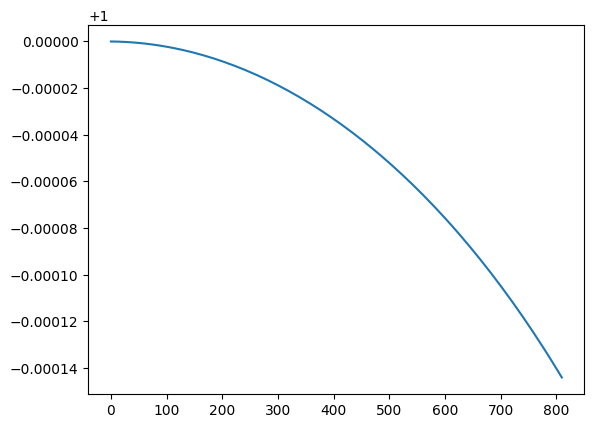

In [97]:
plt.plot(xc, sim.xh[sim.N//2:,sim.N//2,sim.N//2])

In [96]:
np.interp(0.5, sim.xh[sim.N//2:,sim.N//2,sim.N//2], xc)

0.0

In [72]:
xc = np.linspace(0, sim.boxsize*1000/2, sim.N//2)
np.interp(0.5, np.flip(sim.xh[sim.N//2:,sim.N//2,sim.N//2]), np.flip(xc))

480.30413076527736

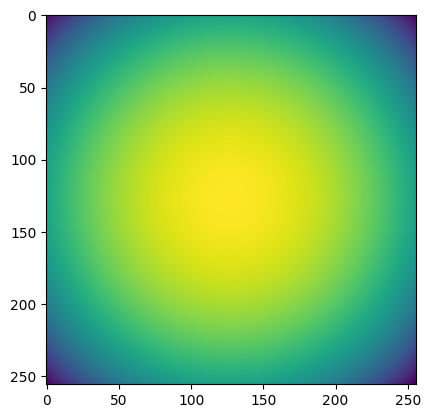

In [101]:
plt.imshow(sim.xh[:,:,sim.N//2])
#[:sim.N//2+1,sim.N//2,sim.N//2]

In [102]:
timer.summary

'\n--- TIMER SUMMARY ---\n step 1: 3m 55.44s - k=0, t=0\n step 2: 2m 16.03s - k=1, t=0\n step 3: 2m 3.13s - k=2, t=0\n step 4: 1m 59.51s - k=3, t=0\n step 5: 1m 15.10s - k=4, t=0\n step 6: 7.41s - k=5, t=0\n step 7: 7.32s - k=6, t=0\n step 8: 7.17s - k=7, t=0\n step 9: 7.49s - k=8, t=0\n step 10: 7.37s - k=9, t=0\nElapsed time: 12m 5.96s '

In [104]:
t_num = np.arange(numzred)*dt*u.s
t_num.to('Myr')

<Quantity [  0.        ,  50.00000105, 100.00000211, 150.00000316,
           200.00000422, 250.00000527, 300.00000632, 350.00000738,
           400.00000843, 450.00000948] Myr>

In [105]:
r_num

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

AttributeError: 'list' object has no attribute 'to'

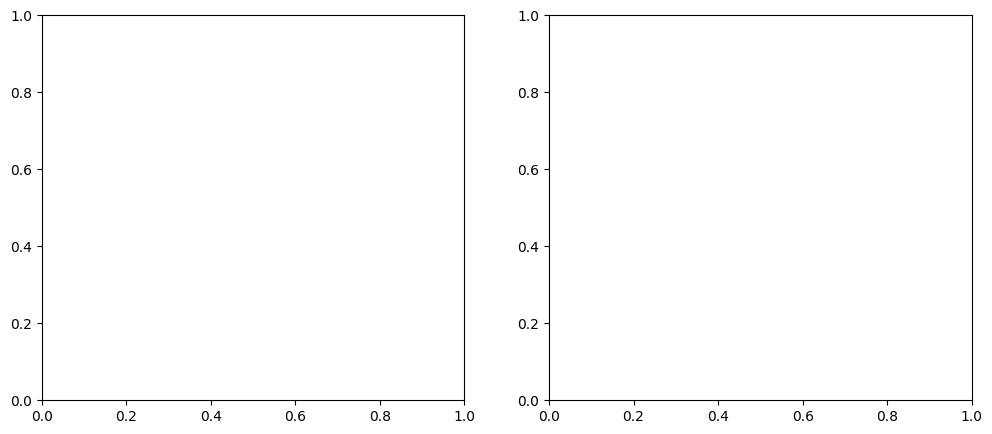

In [103]:
fig, axs = plt.subplots(figsize=(12,5), ncols=2, nrows=1)

#axs[0].plot(t_analytical, r_analytical, color='black', ls='-', label="Analytical", lw=2)
axs[0].plot(t_num.to('Myr'), r_num, color='tab:blue', ls='--', label="Numerical", lw=2)
axs[0].set_ylabel("$r_I(t)$ [kpc]")

axs[1].semilogy(t_analytical[1:],v_analytical,color='black',label="Analytical",lw=2)
#axs[1].plot(t_ave, v_num, color='tab:blue', ls='--', label="Numerical", lw=2)
axs[1].set_ylabel("$v_I(t)$ [km s$^{-1}$]")

for ax in axs:
    ax.set_xlabel("$t$ [Myr]")
    ax.grid()
    ax.legend()

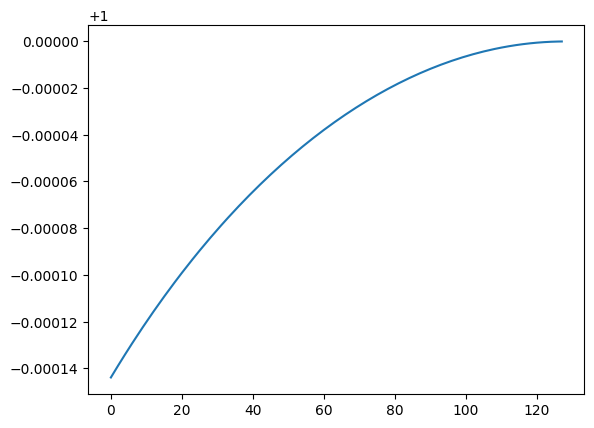

In [56]:
plt.plot(sim.xh[:sim.N//2,sim.N//2,sim.N//2])